In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter
import pandas as pd

import central_system as cs
import analyze_control as ac
import read_load as rl

import report_study_case
import report_system_spec
import report_house_spec
import report_general_property
import report_external_conditions
import report_general_property
import report_occupant_usage

Importing Jupyter notebook from report_study_case.ipynb
Importing Jupyter notebook from report_system_spec.ipynb
Importing Jupyter notebook from report_house_spec.ipynb
Importing Jupyter notebook from report_general_property.ipynb
Importing Jupyter notebook from report_external_conditions.ipynb
Importing Jupyter notebook from report_occupant_usage.ipynb


# 循環風量

本モジュールではシステムの循環風量の計算方法について示します。  

## 0. 検討ケース

試算するケースを取得します。

In [2]:
case = report_study_case.get_case()
case

{'region': 6,
 'house': {'a_mr': 29.81,
  'a_or': 51.34,
  'a_a': 120.08,
  'r_env': 2.9555555555555557,
  'insulation': 'h11',
  'solar_gain': 'middle'},
 'system': {'default_heat_source_spec': True,
  'v_hs_rtd_h': 1800.0,
  'v_hs_rtd_c': 1800.0,
  'is_duct_insulated': True,
  'vav_system': False,
  'cap_rtd_h': None,
  'cap_rtd_c': None}}

## 1. 外部モジュールの読み込み

### 熱源機の仕様

外部モジュール report_external_conditions を参照のこと。

$q_{rtd,H}$：定格暖房能力, W  
$q_{rtd,C}$：定格冷房能力, W  
$V_{hs,rtd,H}$：熱源機の暖房時の定格風量, m<sup>3</sup>/h  
$V_{hs,rtd,C}$：熱源機の冷房時の定格風量, m<sup>3</sup>/h  

In [3]:
q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system = \
    report_system_spec.get_system_spec(case['region'], case['house']['a_a'], case['system'])

q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system

(7733.9925600000015, 7664.646360000001, 1800.0, 1800.0, True, False)

### 住宅の仕様

外部モジュール report_external_conditions を参照のこと。  

$r_{env}$：床面積の合計に対する外皮の部位の面積の合計の比  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他の居室の床面積, m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$A_{HCZ,R,i}$：標準住戸における暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\mu_H$：暖房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$\mu_C$：冷房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  

In [4]:
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent = \
    report_house_spec.get_house_spec(case['region'], case['house'])
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent

(2.9555555555555557,
 120.08,
 29.81,
 51.34,
 38.92999999999999,
 array([29.81, 16.56, 13.25, 10.76, 10.77,  3.31,  1.66,  3.31, 13.25,
         4.97, 10.77,  1.66]),
 array([37.99636619, 27.7187943 , 22.17838312, 18.01052093, 18.02725933]),
 2.1739130434782608,
 2.7,
 0.101,
 0.062,
 array([60., 20., 40., 20., 20.]))

### 物性値

外部モジュール report_general_property を参照のこと。

$\rho$：空気の密度, kg/m<sup>3</sup>  
$c$：空気の比熱, J/kgK  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
暖冷房期間

In [5]:
rho, c, l_wtr, calender = report_general_property.get_general_property()
rho, c, l_wtr, calender

(1.2,
 1006.0,
 2434.5296000000003,
 array(['休日', '休日', '休日', ..., '休日', '休日', '休日'], dtype=object))

### 気候条件

外部モジュール report_external_conditions を参照のこと。

$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, ℃  
$x_{ex,d,t}$：日付$d$の時刻$t$における絶対湿度, kg/kg(DA)  
$h_{ex_d,t}$：日付$d$の時刻$t$における相対湿度, %  
$J_{d,t}$：日付$d$の時刻$t$における水平面全天日射量, W/m<sup>2</sup>  
$\theta_{SAT,d,t}$：日付$d$の時刻$t$における水平面における等価外気温度, ℃  

In [6]:
theta_ex, x_ex, h_ex, j, theta_sat = report_external_conditions.get_external_conditions(case['region'])

### 居住者の使い方

外部モジュール report_occupant_usage を参照のこと。

暖房期間  
冷房期間  
$n_{p,d,t}$：日付$d$の時刻$t$における在室人数  


In [7]:
heating_period, cooling_period, n_p, q_gen = report_occupant_usage.get_occupant_usage(case['region'], a_mr, a_or, a_nr, calender)
heating_period, cooling_period, n_p, q_gen

(array([ True,  True,  True, ...,  True,  True,  True]),
 array([False, False, False, ..., False, False, False]),
 array([4., 4., 4., ..., 4., 3., 3.]),
 array([126.4, 126.4, 126.4, ..., 763. , 815. , 242.7]))

## 2. 熱源機の風量を計算するための熱源機の出力

## 循環風量の予測に用いる暖冷房負荷

循環風量（熱源機送風量）は居室の温度や戻り空気の温度をセンサリングして決定されており、基本的には暖冷房負荷の多寡に応じて決定されていると言える。本計算方法では暖冷房負荷に応じて循環風量を決定することとしている。一方で、暖冷房負荷（特に非居室の暖冷房負荷）は循環風量に応じて決まるため、厳密には収束計算が発生する。現実世界ではPID制御等を用いて過去のデータから循環風量を決定しているが、本計算方法ではその方法は非常に詳細すぎるし、現時点で得られる暖冷房負荷は1時間ごとの暖冷房負荷であるため、1時間前のデータから現在の暖冷房負荷を予測するのは著しく精度が落ちることが想像できる。（ただし、15分間隔の負荷計算等をするのではこの限りではない。）そこで、簡易的な定常計算を行うことにより暖冷房負荷の予測を行うこととする。また、ここでは、実際に暖冷房負荷計算した結果（シムヒートのデータ）と比較を行う。

### シムヒートのデータ

In [8]:
l_h, l_cs, l_cl = cs.get_load(region=case['region'], insulation=case['house']['insulation'], solar_gain=case['house']['solar_gain'],
                  a_mr=case['house']['a_mr'], a_or=case['house']['a_or'], a_a=case['house']['a_a'], r_env=case['house']['r_env'])

### 年間スケジュール

### 在室人数スケジュール

$n_{p,d,t}$：日付$d$の時刻$t$における在室人数  
$n_{p,MR,d,t}$：日付$d$の時刻$t$における主たる居室の在室人数  
$n_{p,MR,d,t}$：日付$d$の時刻$t$におけるその他の居室の在室人数  
$n_{p,MR,d,t}$：日付$d$の時刻$t$における非居室の在室人数  

In [9]:
n_p, n_p_mr, n_p_or, n_p_nr = cs.get_n_p(a_mr, a_or, a_nr, calender)
n_p, n_p_mr, n_p_or, n_p_nr

(array([4., 4., 4., ..., 4., 3., 3.]),
 array([0., 0., 0., ..., 2., 1., 0.]),
 array([4., 4., 4., ..., 2., 2., 3.]),
 array([0., 0., 0., ..., 0., 0., 0.]))

### 内部発熱スケジュール

$q_{gen,d,t}$：日付$d$の時刻$t$における内部発熱, W    
$q_{gen,MR,d,t}$：日付$d$の時刻$t$における主たる居室の内部発熱, W    
$q_{gen,MR,d,t}$：日付$d$の時刻$t$におけるその他の居室の内部発熱, W  
$q_{gen,MR,d,t}$：日付$d$の時刻$t$における非居室の内部発熱, W  

In [10]:
q_gen, q_gen_mr, q_gen_or, q_gen_nr = cs.get_q_gen(a_mr, a_or, a_nr, calender)
q_gen, q_gen_mr, q_gen_or, q_gen_nr

(array([126.4, 126.4, 126.4, ..., 763. , 815. , 242.7]),
 array([ 66.9,  66.9,  66.9, ..., 339.1, 312.9,  66.9]),
 array([ 18. ,  18. ,  18. , ..., 168.8, 270. ,  18. ]),
 array([ 41.5,  41.5,  41.5, ..., 255.1, 232.1, 157.8]))

### 内部発湿スケジュール

$$ w_{gen,MR,d,t} = w_{s,gen,MR,d,t} \frac{ A_{MR} }{ 29.81 } $$  
$$ w_{gen,OR,d,t} = w_{s,gen,OR,d,t} \frac{ A_{OR} }{ 51.34 } $$  
$$ w_{gen,NR,d,t} = w_{s,gen,NR,d,t} \frac{ A_{NR} }{ 38.93 } $$  

$w_{gen,MR,d,t}$：日付$d$の時刻$t$における主たる居室の内部発湿, g/h    
$w_{gen,NR,d,t}$：日付$d$の時刻$t$におけるその他の居室の内部発湿, g/h  
$w_{gen,OR,d,t}$：日付$d$の時刻$t$における非居室の内部発湿, g/h  
$w_{s,gen,MR,d,t}$：日付$d$の時刻$t$における標準住戸の主たる居室の内部発湿, g/h    
$w_{s,gen,NR,d,t}$：日付$d$の時刻$t$における標準住戸のその他の居室の内部発湿, g/h  
$w_{s,gen,OR,d,t}$：日付$d$の時刻$t$における標準住戸の非居室の内部発湿, g/h  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他居室の床面積, m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  

標準住戸における内部発湿, g/h

平日

| 居室の種類 | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 主たる居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 25.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 50.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |  
| その他の居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| 非居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |

休日

| 居室の種類 | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 主たる居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 25.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 50.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |  
| その他の居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| 非居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |


In [11]:
w_gen_mr_wd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0
]) * a_mr / 29.81

w_gen_or_wd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
]) * a_or / 51.34

w_gen_nr_wd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
]) * a_nr / 38.93

w_gen_mr_hd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
]) * a_mr / 29.81

w_gen_or_hd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
]) * a_or / 51.34

w_gen_nr_hd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
]) * a_nr / 38.93

w_gen_mr = np.tile(w_gen_mr_wd, 365) * (calender == '平日') + np.tile(w_gen_mr_hd, 365) * (calender == '休日')
w_gen_or = np.tile(w_gen_or_wd, 365) * (calender == '平日') + np.tile(w_gen_or_hd, 365) * (calender == '休日')
w_gen_nr = np.tile(w_gen_nr_wd, 365) * (calender == '平日') + np.tile(w_gen_nr_hd, 365) * (calender == '休日')

w_gen_mr, w_gen_or, w_gen_nr

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]))

### 局所換気スケジュール

局所換気量は、住宅規模に関わらず次表で表されることとする。

$V_{local,MR,d,t}$：日付$d$時刻$t$における主たる居室の局所換気量, m<sup>3</sup>/h  
$V_{local,OR,d,t}$：日付$d$時刻$t$におけるその他の居室の局所換気量, m<sup>3</sup>/h  
$V_{local,NR,d,t}$：日付$d$時刻$t$における非居室の局所換気量, m<sup>3</sup>/h  

平日

| 居室の種類 | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 主たる居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 75.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 75.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 150.0 | 150.0 | 0.0 | 0.0 | 0.0 | 0.0 |  
| その他の居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |  
| 非居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 6.0 | 2.0 | 0.0 | 0.8 | 0.0 | 0.0 | 0.8 | 0.0 | 0.0 | 0.0 | 0.8 | 0.8 | 0.8 | 0.8 | 0.8 | 52.0 | 25.0 | 102.8.0 |  

休日

| 居室の種類 | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |  
| 主たる居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 75.0 | 0.0 | 0.0 | 0.0 | 75.0 | 0.0 | 0.0 | 0.0 | 0.0 | 150.0 | 150.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |  
| その他の居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |  
| 非居室 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 4.0 | 4.0 | 0.0 | 1.2 | 1.2 | 0.0 | 0.0 | 0.0 | 0.0 | 2.0 | 75.8 | 25.0 | 2.0 | 0.8 | 25.0 | 27.0 | 100.8 |  

In [12]:
v_local_mr_wd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.0, 0.0,  0.0, 0.0, 0.0, 0.0, 75.0, 0.0, 0.0, 0.0, 0.0,   0.0, 150.0, 150.0, 0.0,  0.0,  0.0,   0.0])
v_local_or_wd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  0.0, 0.0,  0.0, 0.0, 0.0, 0.0,  0.0, 0.0, 0.0, 0.0, 0.0,   0.0,   0.0,   0.0, 0.0,  0.0,  0.0,   0.0])
v_local_nr_wd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  6.0, 2.0,  0.0, 0.8, 0.0, 0.0,  0.8, 0.0, 0.0, 0.0, 0.8,   0.8,   0.8,   0.8, 0.8, 52.0, 25.0, 102.8])
v_local_mr_hd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  0.0, 0.0, 75.0, 0.0, 0.0, 0.0, 75.0, 0.0, 0.0, 0.0, 0.0, 150.0, 150.0,   0.0, 0.0,  0.0,  0.0,   0.0])
v_local_or_hd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  0.0, 0.0,  0.0, 0.0, 0.0, 0.0,  0.0, 0.0, 0.0, 0.0, 0.0,   0.0,   0.0,   0.0, 0.0,  0.0,  0.0,   0.0])
v_local_nr_hd = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  0.0, 4.0,  4.0, 0.0, 1.2, 1.2,  0.0, 0.0, 0.0, 0.0, 2.0,  75.8,  25.0,   2.0, 0.8, 25.0, 27.0, 100.8])

v_local_mr = np.tile(v_local_mr_wd, 365) * (calender == '平日') + np.tile(v_local_mr_hd, 365) * (calender == '休日')
v_local_or = np.tile(v_local_or_wd, 365) * (calender == '平日') + np.tile(v_local_or_hd, 365) * (calender == '休日')
v_local_nr = np.tile(v_local_nr_wd, 365) * (calender == '平日') + np.tile(v_local_nr_hd, 365) * (calender == '休日')

v_local_mr, v_local_or, v_local_nr

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]))

### 簡易予測式に用いる内部発熱スケジュール（1日）

#### 方法1（暖房）

$$ Q'_{hs,H,d,t} = Q'_{hs,H,ac,d,t} + Q'_{hs,H,nac,d,t}$$ 

$$ Q'_{hs,H,ac,d,t} = \max \left( \left( \left( (Q - 0.35 \times 0.5 \times 2.4) (A_{MR} + A_{OR}) + c \rho \frac{ ( V_{local,MR,d,t} + V_{local,OR,d,t} + \sum_{i=1}^5{V_{vent,i}} ) }{ 3600 } \right) (\theta_{ac,H} - \theta_{ex,d,t}) - \mu_H (A_{MR} + A_{OR}) J_{d,t} - (q_{gen,MR,d,t} + q_{gen,OR,d,t}) - (n_{p,MR,d,t} + n_{p,OR,d,t}) q_{p,H} \right) \times 3600 \times 10^{-6}, 0.0 \right) $$

$$ Q'_{hs,H,nac,d,t} = \max \left( \left( \left( (Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } \right) (\theta_{ac,H} - \theta_{ex,d,t}) - \mu_H A_{NR} J_{d,t} - q_{gen,NR,d,t} - n_{p,NR,d,t} q_{p,H} \right) \times 3600 \times 10^{-6}, 0.0 \right) $$

#### 方法1（冷房）

$$ Q'_{hs,C,d,t} = Q'_{hs,CS,ac,d,t} + Q'_{hs,CL,ac,d,t} + Q'_{hs,CS,nac,d,t} + Q'_{hs,CL,nac,d,t}$$ 

$$ Q'_{hs,CS,ac,d,t} = \max \left( \left( \left( (Q - 0.35 \times 0.5 \times 2.4) (A_{MR} + A_{OR}) + c \rho \frac{ ( V_{local,MR,d,t} + V_{local,OR,d,t} + \sum_{i=1}^5{V_{vent,i}} ) }{ 3600 } \right) (\theta_{ex,d,t} - \theta_{ac,C}) + \mu_C (A_{MR} + A_{OR}) J_{d,t} + (q_{gen,MR,d,t} + q_{gen,OR,d,t}) + (n_{p,MR,d,t} + n_{p,OR,d,t}) q_{p,CS} \right) \times 3600 \times 10^{-6}, 0.0 \right) $$

$$ Q'_{hs,CS,nac,d,t} = \max \left( \left( \left( (Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } \right) (\theta_{ex,d,t} - \theta_{ac,C}) + \mu_C A_{NR} J_{d,t} + q_{gen,NR,d,t} + n_{p,NR,d,t} q_{p,CS} \right) \times 3600 \times 10^{-6}, 0.0 \right) $$

$$ Q'_{hs,CL,ac,d,t} = \max \left( \left( \left( ( V_{local,MR,d,t} + V_{local,OR,d,t} + \sum_{i=1}^5{V_{vent,i}} ) \rho \left( X_{ex,d,t} - X_{ac,C} \right)  \times 10^3 + (w_{gen,MR,d,t} + w_{gen,OR,d,t}) \right) l_{wtr} + (n_{p,MR,d,t} + n_{p,OR,d,t}) q_{p,CL} \right) \times 10^{-6}, 0.0 \right) $$

$$ Q'_{hs,CL,nac,d,t} = \max \left( \left( \left( V_{local,NR,d,t} \rho \left( X_{ex,d,t} - X_{ac,C} \right) \times 10^3 + w_{gen,NR,d,t} \right) l_{wtr} + n_{p,NR,d,t} q_{p,CL} \right) \times 10^{-6}, 0.0 \right) $$

#### 方法2

$$ Q'_{hs,H,d,t} = \max \left( \left( \left( \left( Q - 0.35 \times 0.5 \times 2.4 \right) A_A + c \rho \frac{ V_{local,d,t} + \sum_{i=1}^5{V_{vent,i}} }{ 3600 } \right) \left( \theta_{ac,H} - \theta_{ex,d,t} \right) - \mu_H A_A J_{d,t} - q_{gen,d,t} - n_{p,d,t} q_{p,H} \right) \times 3600 \times 10^{-6}, 0.0 \right) $$

$$ Q'_{hs,CS,d,t} = \max \left( \left( \left( \left( Q - 0.35 \times 0.5 \times 2.4 \right) A_A + c \rho \frac{ V_{local,d,t} + \sum_{i=1}^5{V_{vent,i}} }{ 3600 } \right) \left( \theta_{ex,d,t} - \theta_{ac,C} \right) + \mu_C A_A J_{d,t} + q_{gen,d,t} + n_{p,d,t} q_{p,CS} \right) \times 3600 \times 10^{-6}, 0.0 \right) $$

$$ Q'_{hs,CL,d,t} = \max \left( \left( \left( ( V_{local,d,t} + \sum_{i=1}^5{V_{vent,i}} ) \rho \left( X_{ex,d,t} - X_{ac,C} \right)  \times 10^3 + w_{gen,d,t} \right) l_{wtr} + n_{p,d,t} q_{p,CL} \times 3600 \right) \times 10^{-6}, 0.0 \right) $$

$$ V_{local,d,t} = V_{local,MR,d,t} + V_{local,OR,d,t} + V_{local,NR,d,t} $$

$$ w_{gen,d,t} = w_{gen,MR,d,t} + w_{gen,OR,d,t} + w_{gen,NR,d,t} $$

$Q'_{hs,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの暖房時の熱源機の風量を計算するための熱源機の出力, MJ/h  
$Q'_{hs,H,ac,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの暖房時の熱源機の風量を計算するための熱源機の出力(居室分), MJ/h  
$Q'_{hs,H,nac,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの暖房時の熱源機の風量を計算するための熱源機の出力(非居室分), MJ/h  
$Q'_{hs,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房時の熱源機の風量を計算するための熱源機の出力, MJ/h  
$Q'_{hs,CS,ac,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房時の熱源機の風量を計算するための熱源機の顕熱出力(居室分), MJ/h  
$Q'_{hs,CS,nac,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房時の熱源機の風量を計算するための熱源機の顕熱出力(非居室分), MJ/h  
$Q'_{hs,CL,ac,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房時の熱源機の風量を計算するための熱源機の潜熱出力(居室分), MJ/h  
$Q'_{hs,CL,nac,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房時の熱源機の風量を計算するための熱源機の潜熱出力(非居室分), MJ/h  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\mu_H$：暖房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$\mu_C$：冷房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他の居室の床面積, m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{local,MR,d,t}$：日付$d$時刻$t$における主たる居室の局所換気量, m<sup>3</sup>/h  
$V_{local,OR,d,t}$：日付$d$時刻$t$におけるその他の居室の局所換気量, m<sup>3</sup>/h  
$V_{local,NR,d,t}$：日付$d$時刻$t$における非居室の局所換気量, m<sup>3</sup>/h  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  
$q_{gen,MR,d,t}$：日付$d$の時刻$t$における主たる居室の内部発熱, W    
$q_{gen,OR,d,t}$：日付$d$の時刻$t$におけるその他の居室の内部発熱, W  
$q_{gen,NR,d,t}$：日付$d$の時刻$t$における非居室の内部発熱, W  
$n_{p,MR,d,t}$：日付$d$の時刻$t$における主たる居室の在室人数  
$n_{p,OR,d,t}$：日付$d$の時刻$t$におけるその他の居室の在室人数  
$n_{p,NR,d,t}$：日付$d$の時刻$t$における非居室の在室人数  
$w_{gen,MR,d,t}$：日付$d$の時刻$t$における主たる居室の内部発湿, g/h    
$w_{gen,OR,d,t}$：日付$d$の時刻$t$におけるその他の居室の内部発湿, g/h  
$w_{gen,NR,d,t}$：日付$d$の時刻$t$における非居室の内部発湿, g/h  
$q_{p,H}$：暖房期の居住者1人当りの顕熱発熱量, W  
$q_{p,CS}$：冷房期の居住者1人当りの顕熱発熱量, W  
$q_{p,CL}$：冷房期の居住者1人当りの潜熱発熱量, W  
$\theta_{ac,H}$：暖房時の暖冷房区画の温度, ℃  
$\theta_{ac,C}$：冷房時の暖冷房区画の温度, ℃  
$\theta_{ex,d,t}$：日付 $d$ の時刻 $t$ における外気温度, ℃  
$J_{d,t}$：日付 $d$ の時刻 $t$ における水平面全天日射量, W/m<sup>2</sup>  
$X_{ex,d,t}$：日付$d$の時刻$t$における絶対湿度, kg/kg(DA)  
$X_{ac,C}$：冷房時の暖冷房区画の絶対湿度, kg/kg(DA)

In [13]:
q_d_hs_h_ac = np.maximum(
    ( ((q - 0.35 * 0.5 * 2.4) * (a_mr + a_or) + c * rho * (v_local_mr + v_local_or + sum(v_vent)) / 3600 ) * (20.0 - theta_ex)
     - mu_h * (a_mr + a_or) * j
     - (q_gen_mr + q_gen_or) - (n_p_mr + n_p_or) * 79) * 3600 * 10**(-6), 0.0) * heating_period

In [14]:
q_d_hs_h_nac = np.maximum(
    ( ((q - 0.35 * 0.5 * 2.4) * a_nr + c * rho * v_local_nr / 3600) * (20.0 - theta_ex)
     - mu_h * a_nr * j
     - q_gen_nr - n_p_nr * 79) * 3600 * 10**(-6), 0.0) * heating_period

In [15]:
q_d_hs_h = q_d_hs_h_ac + q_d_hs_h_nac

In [16]:
q_d_hs_cs_ac = np.maximum(
    ( ((q - 0.35 * 0.5 * 2.4) * (a_mr + a_or) + c * rho * (v_local_mr + v_local_or + sum(v_vent)) / 3600 ) * (theta_ex - 27.0)
     + mu_c * (a_mr + a_or) * j
     + (q_gen_mr + q_gen_or) + (n_p_mr + n_p_or) * 51) * 3600 * 10**(-6), 0.0) * cooling_period

In [17]:
q_d_hs_cs_nac = np.maximum(
    ( ((q - 0.35 * 0.5 * 2.4) * a_nr + c * rho * v_local_nr / 3600) * (theta_ex - 27.0) + mu_c * a_nr * j
     + q_gen_nr + n_p_nr * 51) * 3600 * 10**(-6), 0.0) * cooling_period

In [18]:
q_d_hs_cs = q_d_hs_cs_ac + q_d_hs_cs_nac

In [19]:
q_d_hs_cl_ac = np.maximum(
    ( ((v_local_mr + v_local_or + sum(v_vent)) * rho * (x_ex - 0.013425743) * 10**3 + (w_gen_mr + w_gen_or) ) * l_wtr
     + (n_p_mr + n_p_or) * 40.0 * 3600) * 10**(-6) , 0.0) * cooling_period

In [20]:
q_d_hs_cl_nac = np.maximum(
    ( (v_local_nr * rho * (x_ex - 0.013425743) * 10**3 + w_gen_nr ) * l_wtr + n_p_nr* 40.0 * 3600) * 10**(-6) , 0.0
) * cooling_period

In [21]:
q_d_hs_cl = q_d_hs_cl_ac + q_d_hs_cl_nac

#### 方法2

In [22]:
q_d_hs_h2 = np.maximum( 
    (((q - 0.35 * 0.5 * 2.4) * a_a + c * rho * (v_local_mr + v_local_or + v_local_nr + + sum(v_vent)) / 3600) * (20.0- theta_ex)
     - mu_h * a_a * j
     - (q_gen_mr + q_gen_or + q_gen_nr) - (n_p_mr + n_p_or + n_p_nr) * 79.0 ) * 3600 * 10**(-6), 0.0) * heating_period

In [23]:
q_d_hs_cs2 = np.maximum(
    ( ((q - 0.35 * 0.5 * 2.4) * a_a + c * rho * (v_local_mr + v_local_or + v_local_nr + sum(v_vent)) / 3600 ) * (theta_ex - 27.0)
     + mu_c * a_a * j
     + (q_gen_mr + q_gen_or + q_gen_nr) + (n_p_mr + n_p_or + n_p_nr) * 51.0 ) * 3600 * 10**(-6), 0.0) * cooling_period

In [24]:
q_d_hs_cl2 = np.maximum(
    ( ((v_local_mr + v_local_or + v_local_nr + sum(v_vent)) * rho * (x_ex - 0.013425743) * 10**3 + (w_gen_mr + w_gen_or + w_gen_nr) ) * l_wtr
     + (n_p_mr + n_p_or + n_p_nr) * 40.0 * 3600) * 10**(-6) , 0.0) * cooling_period

In [25]:
def draw_graph_plot45(d1, d2, d3, d4):
    
    def plot45(ax, xs, ys, title):
        ax.scatter(xs, ys)
        max_value = max(np.max(xs), np.max(ys))
        ax.plot([0,max_value],[0,max_value], color='red')
        ax.set_xlabel('estimated, MJ/h')
        ax.set_ylabel('simulated, MJ/h')
        ax.set_title(title)
        return ax

    fig = plt.figure(figsize=(13,13))
    ax1, ax2, ax3, ax4 = fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223), fig.add_subplot(224)
    
    (xs1, ys1) = d1
    (xs2, ys2) = d2
    (xs3, ys3) = d3
    (xs4, ys4) = d4
    
    ax1 = plot45(ax1, xs1, ys1, 'total')
    ax2 = plot45(ax2, xs2, ys2, 'total2')
    ax3 = plot45(ax3, xs3, ys3, 'occupant room')
    ax4 = plot45(ax4, xs4, ys4, 'non occupant room')

    plt.show()

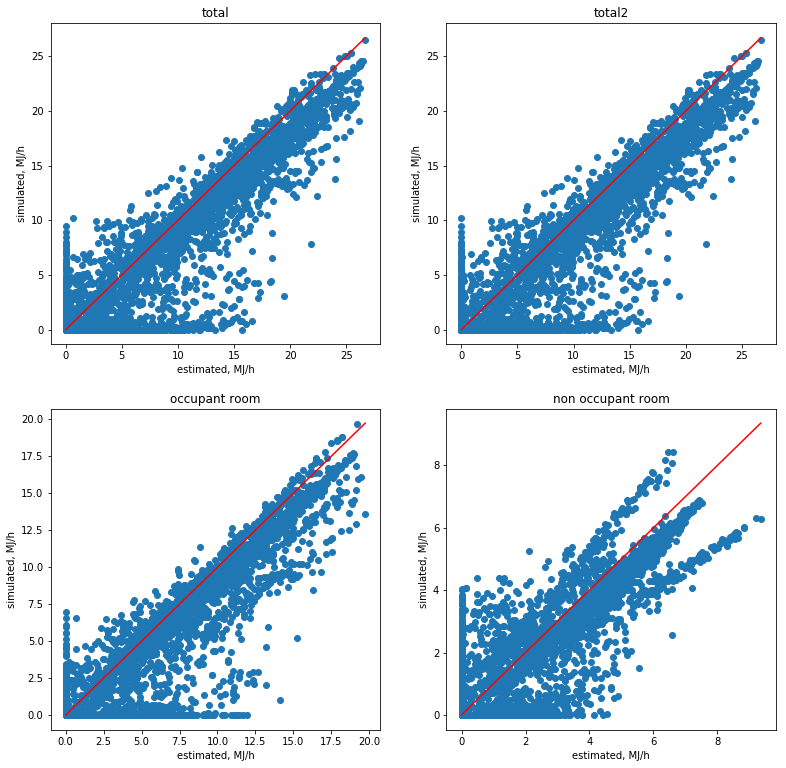

In [26]:
draw_graph_plot45(
    (q_d_hs_h, np.sum(l_h[0:12], axis=0)),
    (q_d_hs_h2, np.sum(l_h[0:12], axis=0)),
    (q_d_hs_h_ac, np.sum(l_h[0:5], axis=0)),
    (q_d_hs_h_nac, np.sum(l_h[5:12], axis=0)))

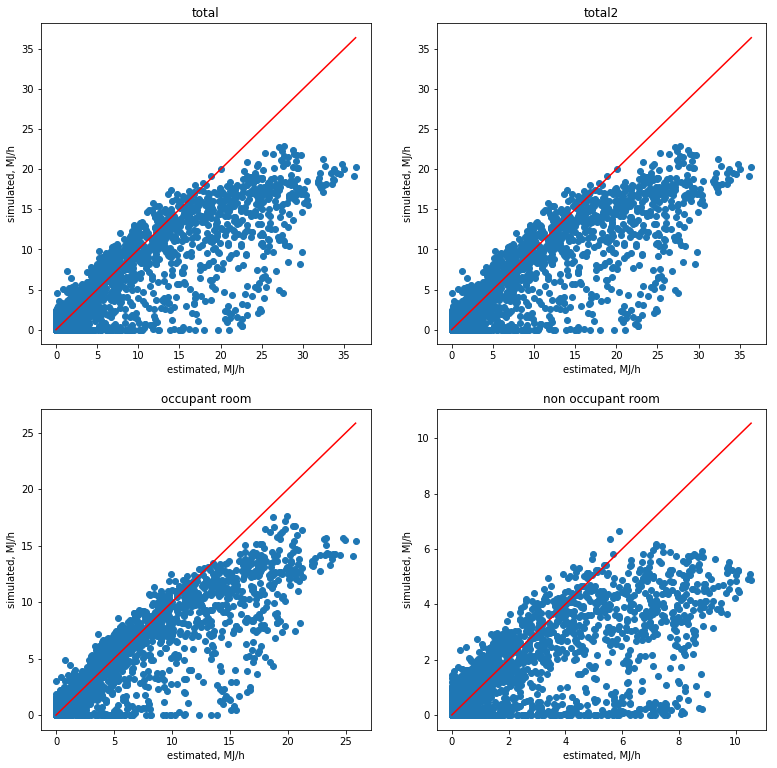

In [27]:
draw_graph_plot45(
    (q_d_hs_cs, np.sum(l_cs[0:12], axis=0)),
    (q_d_hs_cs2, np.sum(l_cs[0:12], axis=0)),
    (q_d_hs_cs_ac, np.sum(l_cs[0:5], axis=0)),
    (q_d_hs_cs_nac, np.sum(l_cs[5:12], axis=0)))

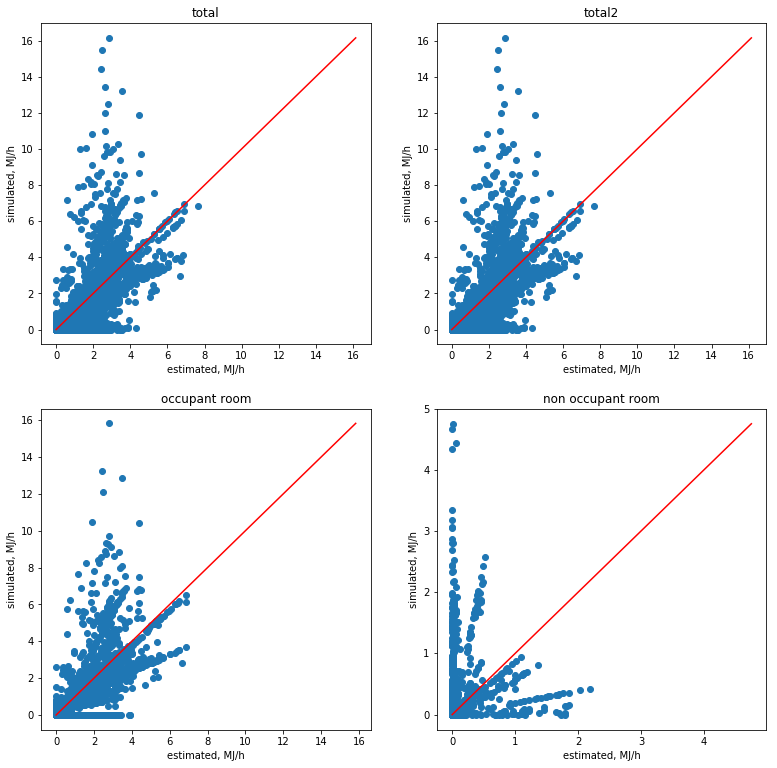

In [28]:
draw_graph_plot45(
    (q_d_hs_cl, np.sum(l_cl[0:12], axis=0)),
    (q_d_hs_cl2, np.sum(l_cl[0:12], axis=0)),
    (q_d_hs_cl_ac, np.sum(l_cl[0:5], axis=0)),
    (q_d_hs_cl_nac, np.sum(l_cl[5:12], axis=0)))

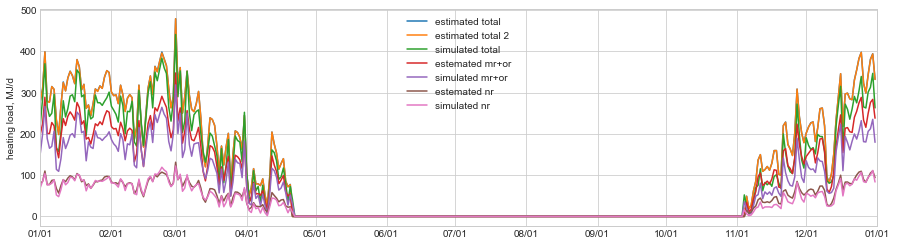

In [29]:
ac.draw_graph(y_title='heating load, MJ/d', ys=[
    (q_d_hs_h_ac + q_d_hs_h_nac, 'estimated total'),
    (q_d_hs_h2, 'estimated total 2'),
    (np.sum(l_h, axis=0), 'simulated total'),
    (q_d_hs_h_ac, 'estemated mr+or'),
    (np.sum(l_h[0:5], axis=0), 'simulated mr+or'),
    (q_d_hs_h_nac, 'estemated nr'),
    (np.sum(l_h[5:12], axis=0), 'simulated nr'),
], op='itg')

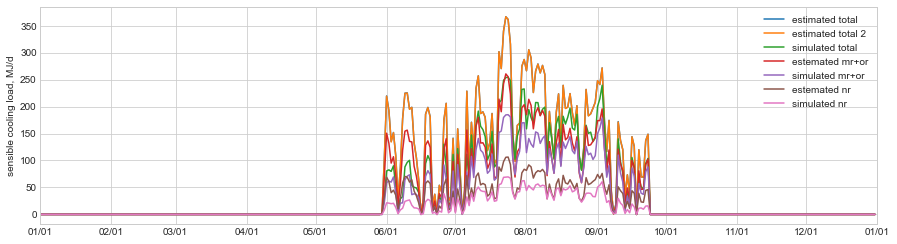

In [30]:
ac.draw_graph(y_title='sensible cooling load, MJ/d', ys=[
    (q_d_hs_cs, 'estimated total'),
    (q_d_hs_cs2, 'estimated total 2'),
    (np.sum(l_cs, axis=0), 'simulated total'),
    (q_d_hs_cs_ac, 'estemated mr+or'),
    (np.sum(l_cs[0:5], axis=0), 'simulated mr+or'),
    (q_d_hs_cs_nac, 'estemated nr'),
    (np.sum(l_cs[5:12], axis=0), 'simulated nr'),
], op='itg')

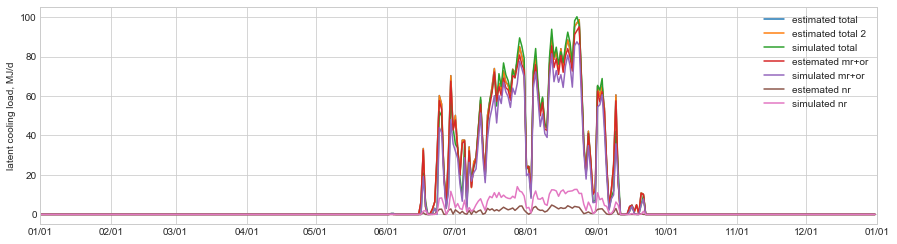

In [31]:
ac.draw_graph(y_title='latent cooling load, MJ/d', ys=[
    (q_d_hs_cl, 'estimated total'),
    (q_d_hs_cl2, 'estimated total 2'),
    (np.sum(l_cl, axis=0), 'simulated total'),
    (q_d_hs_cl_ac, 'estemated mr+or'),
    (np.sum(l_cl[0:5], axis=0), 'simulated mr+or'),
    (q_d_hs_cl_nac, 'estemated nr'),
    (np.sum(l_cl[5:12], axis=0), 'simulated nr'),
], op='itg')